# Trial Summary 

Data preparation:
- Filter genes with less than 10 non-zero expressions spots

Model:
- Nueral Matrix Factorization

Results:
- Train RMSE: 4.06
- Valid RMSE: 6.32
- Test RMSE: 6.42

# Imports

In [ ]:
from os import path, listdir
from copy import deepcopy
import stlearn as st
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import pickle
import torch.optim as optim
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

from scanpy_stlearn_loaders import StlearnLoader
import trainer_nmf as trainer
import data_nmf as get_data
from data_nmf import get_expressions
from models import get_model
import tester_nmf as tester
from loss import *
from results_analysis import *

In [ ]:
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Load Data 

In [ ]:
min_counts = 500
min_cells = 177
apply_log = False
batch_size = 128

In [ ]:
dl_train, dl_valid, dl_test, _ = get_data.main(
    min_counts=min_counts,
    min_cells=min_cells,
    apply_log=apply_log, 
    batch_size=batch_size, 
    device=device
)

# Modelling

## Set HyperParameters

In [ ]:
model_name = 'NMF'
max_epochs = 150
early_stopping = 10
model_params = {
    'learning_rate': 0.1,
    'optimizer': "SGD",
    'latent_dim': 40,
    'batch_size': batch_size
}
trial_name = 'Vanilla'

## Build Model 

In [6]:
model = get_model(model_name, model_params, dl_train)
optimizer = getattr(optim, model_params['optimizer'])(model.parameters(), lr=model_params['learning_rate'])
criterion = RMSELoss()

## Train Model 

In [7]:
model, valid_loss = trainer.train(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    max_epochs=max_epochs,
    early_stopping=early_stopping,
    dl_train=dl_train,
    dl_valid=dl_valid,
    dl_test=dl_test,
    device=device,
    trial_name=trial_name
)

2022-10-01 13:46:07.284999: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-01 13:46:07.506117: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-01 13:46:07.506183: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-01 13:46:07.568524: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-01 13:46:08.963898: W tensorflow/stream_executor/platform/de

Training Results - Epoch[1] Avg loss: 7.52
Validation Results - Epoch[1] Avg loss: 13.91
Training Results - Epoch[2] Avg loss: 6.72
Validation Results - Epoch[2] Avg loss: 13.38
Training Results - Epoch[3] Avg loss: 6.17
Validation Results - Epoch[3] Avg loss: 12.44
Training Results - Epoch[4] Avg loss: 5.31
Validation Results - Epoch[4] Avg loss: 10.23
Training Results - Epoch[5] Avg loss: 5.06
Validation Results - Epoch[5] Avg loss: 9.08
Training Results - Epoch[6] Avg loss: 4.95
Validation Results - Epoch[6] Avg loss: 8.49
Training Results - Epoch[7] Avg loss: 4.85
Validation Results - Epoch[7] Avg loss: 8.01
Training Results - Epoch[8] Avg loss: 4.75
Validation Results - Epoch[8] Avg loss: 7.55
Training Results - Epoch[9] Avg loss: 4.66
Validation Results - Epoch[9] Avg loss: 7.24
Training Results - Epoch[10] Avg loss: 4.57
Validation Results - Epoch[10] Avg loss: 6.87
Training Results - Epoch[11] Avg loss: 4.50
Validation Results - Epoch[11] Avg loss: 6.64
Training Results - Epoch

2022-10-01 16:29:17,484 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Validation Results - Epoch[28] Avg loss: 6.32
Test Results - Avg loss: 6.42


## Test 

In [8]:
_, df_test_preds = tester.test(
    model=model,
    criterion=criterion,
    dl_test=dl_test,
    device=device
)

# Results Analysis 

In [9]:
df_test_preds['y_fixed'] = np.exp(df_test_preds['y'])
df_test_preds['y_pred_fixed'] = np.exp(df_test_preds['y_pred'])

y_col = 'y'
y_pred_col = 'y_pred'

df_test_preds['error'] = df_test_preds[y_col] - df_test_preds[y_pred_col]
df_test_preds.head()

,gene,spot,y,y_pred,y_fixed,y_pred_fixed,error
0,157,711,26.0,14.963966,1.957296e+11,3.153320e+06,11.036034
1,3926,1174,6.0,1.877582,4.034288e+02,6.537676e+00,4.122418
2,4594,951,18.0,19.552034,6.565997e+07,3.099850e+08,-1.552034
3,4019,1117,1.0,0.399572,2.718282e+00,1.491186e+00,0.600428
4,3165,251,1.0,0.592975,2.718282e+00,1.809363e+00,0.407025


## Errors Distribution 

count    852786.000000
mean          1.979243
std          11.909639
min        -111.086853
25%           0.369275
50%           0.936653
75%           1.996080
max        1508.576088
Name: error, dtype: float64


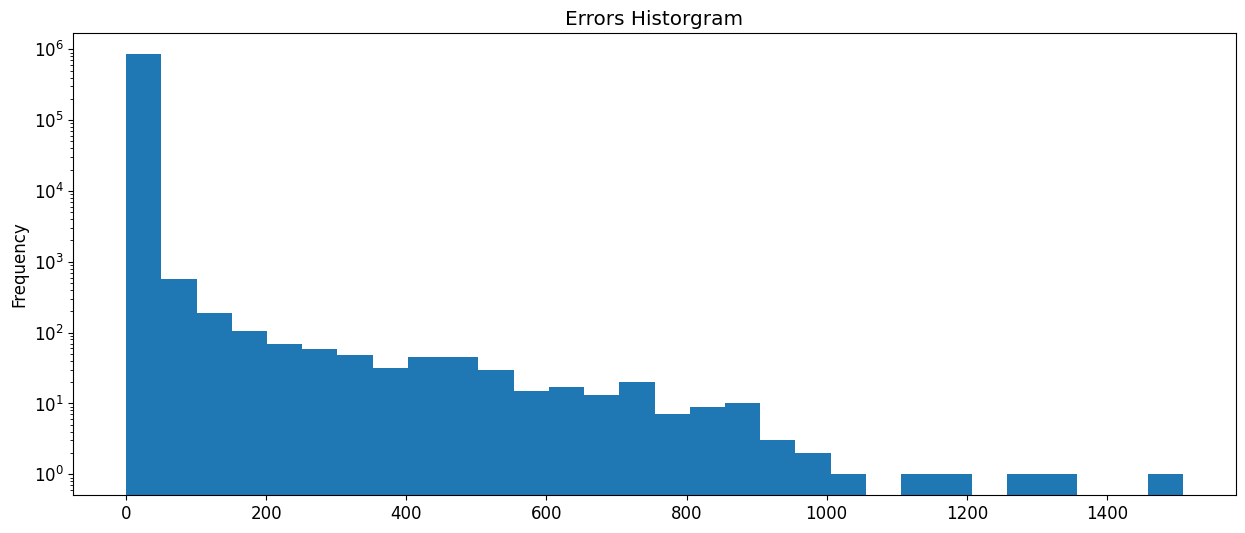

In [10]:
error_distribution(df_test_preds)

## Spots Errors Distribution 

In [11]:
spots_error_distribution(df_test_preds)

count    1185.000000
mean        1.864514
std         0.703487
min         0.681828
25%         1.376431
50%         1.704810
75%         2.155810
max         5.211614
Name: error, dtype: float64


## Genes Errors Distribution 

In [12]:
genes_error_distribution(df_test_preds)

count    6279.000000
mean        1.596460
std         6.032558
min         0.491852
25%         0.959138
50%         1.078471
75%         1.294980
max       336.092306
Name: error, dtype: float64


## Errors Heat Map 

(1185, 6279)


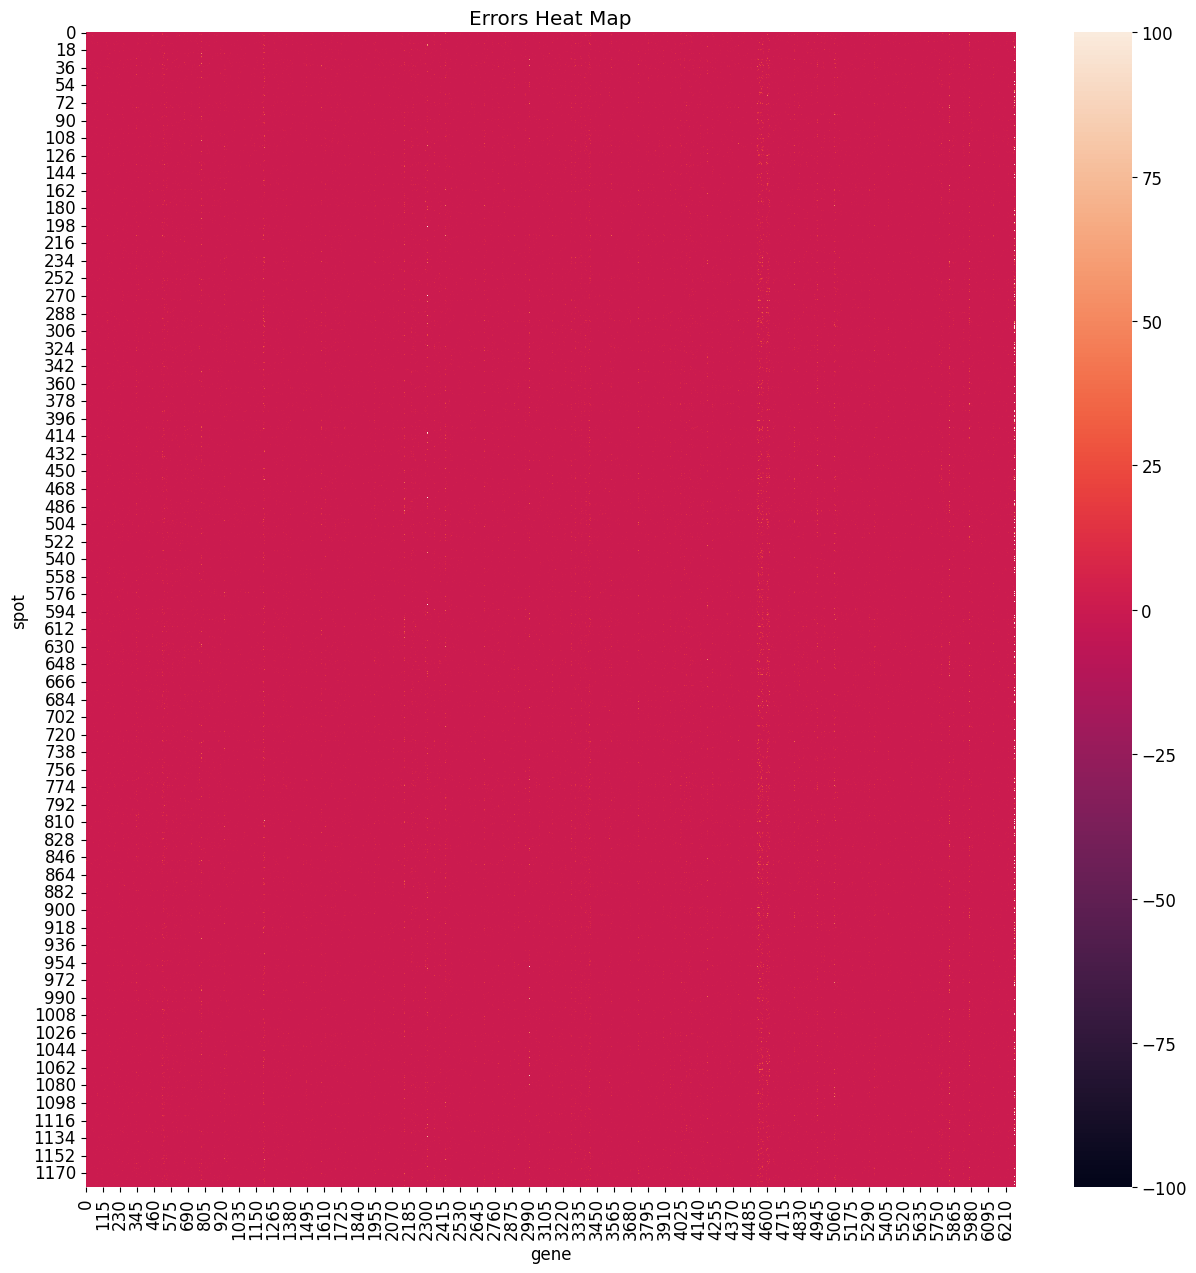

In [13]:
error_heat_map(df_test_preds, vmin=-100, vmax=100)

# PCA + KMeans Clustering 

In [14]:
_, obj, _, _ = get_expressions(min_counts=min_counts, min_cells=min_cells, apply_log=apply_log)

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


# spots: 1185 | # genes: 32285
New shape after filtering: (1185, 6279)
Data shape: (7440615, 3)
Number of genes: 6279
Number of spots: 1185


In [15]:
# Load Ordinal Encoders
with open(path.join('/', 'data', 'NMF', 'genes_encoder.pkl'), 'rb') as f:
    oe_genes = pickle.load(f)
with open(path.join('/', 'data', 'NMF', 'spots_encoder.pkl'), 'rb') as f:
    oe_spots = pickle.load(f)

dl_train_nmf = torch.load(path.join('/', 'data', 'NMF', 'dl_train.pth'))
nmf_train_genes, nmf_train_spots, nmf_train_expressions = dl_train_nmf.dataset.get_all_data()
df_nmf_train_tmp = pd.DataFrame({'gene': nmf_train_genes.to('cpu'), 'spot': nmf_train_spots.to('cpu'), 'expression': nmf_train_expressions.to('cpu')})
df_nmf_train_tmp[['gene']] = oe_genes.inverse_transform(df_nmf_train_tmp[['gene']].values)
df_nmf_train_tmp[['spot']] = oe_spots.inverse_transform(df_nmf_train_tmp[['spot']].values)
df_nmf_train_matrix_tmp = df_nmf_train_tmp.pivot(index='spot', columns='gene', values='expression')

In [16]:
df_nmf_train = df_test_preds[['gene', 'spot', y_pred_col]].rename(columns={y_pred_col: 'expression'})
df_nmf_train[['gene']] = oe_genes.inverse_transform(df_nmf_train[['gene']].values)
df_nmf_train[['spot']] = oe_spots.inverse_transform(df_nmf_train[['spot']].values)
df_nmf_train_matrix = df_nmf_train.pivot(index='spot', columns='gene', values='expression')
df_nmf_train_matrix.fillna(df_nmf_train_matrix_tmp, inplace=True)
df_nmf_train_matrix.clip(lower=0, inplace=True)
display(df_nmf_train_matrix.head())
tmp_genes_locations = [obj.var.index.get_loc(key=gene_key) for gene_key in df_nmf_train_matrix.columns]
# Replace the values
obj.X[:, tmp_genes_locations] = df_nmf_train_matrix.values

gene,0610009B22Rik,0610009L18Rik,0610010K14Rik,0610012G03Rik,1110004F10Rik,1110008P14Rik,1110032A03Rik,1110038B12Rik,1110038F14Rik,1110051M20Rik,...,mt-Co1,mt-Co2,mt-Co3,mt-Cytb,mt-Nd1,mt-Nd2,mt-Nd3,mt-Nd4,mt-Nd4l,mt-Nd5
spot,,,,,,,,,,,,,,,,,,,,,
AAACAAGTATCTCCCA-1,0.0,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.0,0.000000,...,62.000000,28.000000,54.015785,28.0,9.000000,10.309949,4.0,22.0,0.000000,0.0
AAACCGGGTAGGTACC-1,1.0,0.000000,1.344737,4.823371,3.0,2.759608,7.000000,0.017869,0.0,1.768993,...,1587.000000,962.000000,1292.000000,571.0,398.000000,318.000000,58.0,0.0,6.219609,31.0
AAACCGTTCGTCCAGG-1,0.0,0.836204,0.000000,6.000000,7.0,3.090021,0.055383,1.000000,0.0,8.000000,...,832.000000,453.851562,761.000000,339.0,0.000000,171.000000,42.0,278.0,3.000000,0.0
AAACGAGACGGTTGAT-1,1.0,0.000000,2.824153,0.000000,0.0,3.000000,1.000000,0.000000,3.0,4.000000,...,575.000000,0.000000,562.000000,0.0,178.000000,119.000000,25.0,175.0,3.000000,0.0
AAACTGCTGGCTCCAA-1,1.0,0.345293,2.000000,4.000000,0.0,0.000000,0.000000,0.000000,1.0,1.012232,...,389.508484,221.147720,691.000000,306.0,122.648758,0.000000,34.0,0.0,1.000000,27.0


/usr/local/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Normalization step is finished in adata.X
Log transformation step is finished in adata.X
PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']
Applying Kmeans clustering ...
Kmeans clustering is done! The labels are stored in adata.obs["kmeans"]


<Figure size 640x480 with 0 Axes>

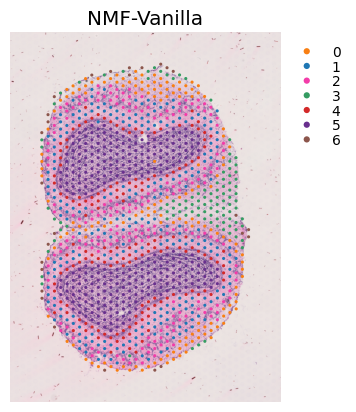

In [17]:
pca_kmeans_clustering(
    data_obj=obj, 
    title=f'NMF-{trial_name}'
)